In [1]:
import os

from ruamel.yaml import YAML
import torch, pyro

from clipppy.patches import torch_numpy
from clipppy import load_config
from clipppy.helpers import scheduled_optimizer_callback_with_loss
from functools import partial

torch.set_default_tensor_type(torch.cuda.FloatTensor)

#### Plotting utilities

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from corner import corner


imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower')

def plot_fit_resids():
    pred = config.ppd()['model_trace'].nodes['mu']['value']

    if len(pred.shape) == 3 and pred.shape[0] == 1:
        pred = pred[0]

    err = (pred - OBS) / NOISE
    vm = err.abs().max()
    err[~MASK] = np.nan

    fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 4))
    imshow_with_cbar(axs[0], OBS / NOISE, **imkwargs, vmin=0, vmax=30)
    imshow_with_cbar(axs[1], pred / NOISE, **imkwargs, vmin=0, vmax=30)
    imshow_with_cbar(axs[2], err, **imkwargs, cmap='bwr', vmin=-vm, vmax=vm)
    plt.tight_layout()


def imshow_with_cbar(ax, img, position='right', cbar_kwargs={}, **kwargs):
    im = ax.imshow(img, **kwargs)
    plt.colorbar(
        im,
        cax=make_axes_locatable(ax).append_axes(position, size='5%', pad=0.05),
        orientation='vertical' if position in ('left',
                                               'right') else 'horizontal',
        **cbar_kwargs)
    return im


def display_guide(params, guide=None, nsamples=1000, ppd=None, exclude=lambda name: False, **kwargs):

    if ppd is None:
        with pyro.plate('plate', nsamples):
            ppd = guide()
    if type(ppd) is tuple:
        ppd = ppd[1]
    ppd = {key: val for key, val in ppd.items() if not exclude(key)}
    names = [k.split('/', 1)[1] if '/' in k else k for k in ppd.keys()]
    truths = [params.get(k, None) for k in ppd.keys()]
    
    for (k, v), name, truth in zip(ppd.items(), names, truths): 
        print(f'{name:>7}: {v.mean():+.5f}±{v.std():.5f} ({truth}{v.mean()-truth:+f}: {abs((truth - v.mean()) / v.std()):.1f}-sigma)')
             
    return corner(np.transpose([v.flatten().numpy() for v in ppd.values()]),
                  labels=[f'{name}={truth:.3f}' for name, truth in zip(names, truths)],
                  truths=truths,
                  **kwargs)

def plot_source(gp):
    X_grid, Y_grid = get_meshgrid(0.003, 400, 400)
    p_grid = torch.stack((X_grid, Y_grid), -1).flatten(0, 1)
    Sigma_grid = gp._get_Sigma(X_grid, Y_grid).flatten(-2, -1).flatten(0, 1)

    imshow_kwargs = {'origin': 'lower', 'extent': [-0.6, 0.6, -0.6, 0.6]}

    gp_src_imgs = gp.flux(p_grid, Sigma_grid).reshape(*gp.batch_shape,
                                                      *X_grid.shape)

    fig, axes = plt.subplots(1, 5, figsize=(16, 4))

    imshow_with_cbar(axes[0], gp_src_imgs.sum(0).numpy(), **imshow_kwargs)

    for i, ax in enumerate(axes.flatten()[1:]):
        imshow_with_cbar(ax, gp_src_imgs[i].numpy(), **imshow_kwargs)
        ax.set_title(r"$\sigma = %f$" % gp.stochastic_specs['sigma'][i].item())

    fig.tight_layout()

    return fig, axes

In [3]:
SYSTEM_NAME = "ngc4414"

os.makedirs(SYSTEM_NAME, exist_ok=True)
BASEDIR = os.path.join(SYSTEM_NAME)
os.makedirs(BASEDIR, exist_ok=True)

#### Load config

In [4]:
PARAMS = YAML().load(open('../paper-source/params.yaml'))[SYSTEM_NAME]

config = load_config('config.yaml', base_dir=BASEDIR)
model, guide = config.umodel, config.guide

OBS = config.conditioning['image']
MASK = config.kwargs['defs']['mask']
NOISE = model.stochastic_specs['sigma_stat']

/home/eliasd/lensing/clipppy/src/clipppy/yaml/constructor.py:55: FutureWarning: Using '__args' for parameter expansion is deprecated and will soon be considered an ordinary keyword argument. Consider using '<' instead.
  warn('Using \'__args\' for parameter expansion is deprecated'
/home/eliasd/lensing/clipppy/src/clipppy/stochastic/stochastic.py:102: RuntimeWarning: Getting items from StochasticSpecs by name is frowned upon and only supports explicitly named specs at the first level that at most come from mappings (no dynamic generation).
  warn(f'Getting items from {type(self).__name__} by name is frowned upon'


In [5]:
GUIDENAME_SP = os.path.join(BASEDIR, f'guide-{SYSTEM_NAME}-sp.pt') # SOURCE PLAN
GUIDENAME_SHALLOW = os.path.join(BASEDIR, f'guide-{SYSTEM_NAME}-shallow.pt') # Just GP on Lens plane
GUIDENAME_FINAL = os.path.join(BASEDIR, f'guide-{SYSTEM_NAME}-final.pt') # above Combined
LOSSESNAME = os.path.join(BASEDIR, f'losses-{SYSTEM_NAME}.pt')

now the sourche is not an image, but a GP (see lines 27 to 48 in yaml file)

In [6]:
model.sources['src'] = config.kwargs['defs']['src'] 
model.sources['gp'] = config.kwargs['defs']['gp']

In [7]:
from clipppy.stochastic import Sampler

# Set initial values (line )
for lens in model.alphas.values():
    for spec in lens.stochastic_specs.values():
        if isinstance(spec, Sampler):
            name = lens.stochastic_name + '/' + spec.name
            if name in PARAMS['init']:
                spec.init = spec.infer['init'] = PARAMS['init'][name]
                
# Fix slope to the truth
model.alphas['main'].stochastic_specs['slope'] = PARAMS['truth']['main/slope']

/home/eliasd/lensing/clipppy/src/clipppy/stochastic/stochastic.py:129: RuntimeWarning: Iterating values from StochasticSpecs is frowned upon and returns the raw specs!
  warn(f'Iterating values from {type(self).__name__} is frowned upon'
/home/eliasd/lensing/clipppy/src/clipppy/stochastic/stochastic.py:113: RuntimeWarning: Setting items on StochasticSpecs by name is frowned upon and only supports explicitly named specs at the first level.
  warn(f'Setting items on {type(self).__name__} by name is frowned upon'


In [8]:
guide.setup()
guide

Guide(
  (gp_alpha): DeltaSamplingGroup(1 sites, torch.Size([3]))
  (gp): DiagonalNormalSamplingGroup(1 sites, torch.Size([480000]))
  (src_alpha): DeltaSamplingGroup(1 sites, torch.Size([1]))
  (g): PartialMultivariateNormalSamplingGroup(8 sites, torch.Size([1607]))
)

## Fitting

#### Initial fit (lens and source plane source)

In [9]:
losses = []

# Remove image plane source and deactivate its guide
model.sources.pop('gp', None)
guide.gp_alpha.active = guide.gp.active = False

if not os.path.isfile(GUIDENAME_SP):
    guide.train()
#     losses += config.fit(lr=1e-2, n_steps=5000)
    losses += config.fit()
    torch.save(guide, GUIDENAME_SP)
    torch.save(losses, LOSSESNAME)

In [10]:
print('Loading', GUIDENAME_SP)
guide_gp, guide_gp_alpha = guide.gp, guide.gp_alpha
guide = config.guide = torch.load(GUIDENAME_SP)
guide.gp, guide.gp_alpha = guide_gp, guide_gp_alpha
if os.path.exists(LOSSESNAME):
    losses = torch.load(LOSSESNAME)

Loading ngc4414/guide-ngc4414-sp.pt


#### Shallow image plane source (fixed lens and source plane source)

In [11]:
# Include image plane source and activate its guide
model.sources['gp'] = config.kwargs['defs']['gp']
guide.gp_alpha.active = guide.gp.active = True

In [12]:
if not os.path.isfile(GUIDENAME_SHALLOW):
    guide.eval()
    guide.gp.train(), guide.gp_alpha.train()

#     losses += config.fit(lr=1e-2, n_steps=5000)
    losses += config.fit()
    torch.save(guide, GUIDENAME_SHALLOW)
    torch.save(losses, LOSSESNAME)

print('Loading', GUIDENAME_SHALLOW)
guide = config.guide = torch.load(GUIDENAME_SHALLOW)
losses = torch.load(LOSSESNAME)

Loading ngc4414/guide-ngc4414-shallow.pt


In [13]:
len(losses)

20077

#### Fit everything

In [14]:
if not os.path.isfile(GUIDENAME_FINAL):
    guide.train()
#     losses += config.fit(lr=1e-3, n_steps=20000, loss_args=dict(num_particles=4))
    losses += config.fit()

    torch.save(losses, LOSSESNAME)
    torch.save(guide, GUIDENAME_FINAL)
    
print('Loading', GUIDENAME_FINAL)
guide = config.guide = torch.load(GUIDENAME_FINAL)
losses = torch.load(LOSSESNAME)

Loading ngc4414/guide-ngc4414-final.pt


In [15]:
# NTOTAL_STEPS = 30000

# if os.path.isfile(GUIDENAME_FINAL):
#     print('Loading', GUIDENAME_FINAL)
#     guide = config.guide = torch.load(GUIDENAME_FINAL)

# guide.train()
# while len(losses) < NTOTAL_STEPS:
#     losses += config.fit(lr=1e-3, n_steps=10000, loss_args=dict(num_particles=1))

#     torch.save(losses, LOSSESNAME)
#     torch.save(guide, GUIDENAME_FINAL)

---

### Plot

In [16]:
losses = torch.load(LOSSESNAME)
guide = config.guide = torch.load(GUIDENAME_FINAL)

##### Loss

In [17]:
LOSSESNAME

'ngc4414/losses-ngc4414.pt'

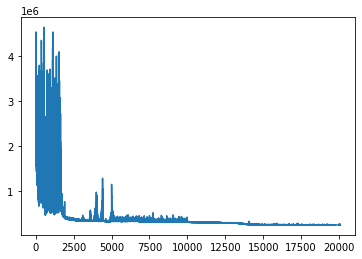

In [18]:
plt.plot(losses)

##### Fit and residuals

In [26]:
import contextlib
from clipppy.guide import fix_guide

In [31]:
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        config.guide = guide = fix_guide(
            torch.load(
                GUIDENAME_FINAL,
                map_location="cuda",
            )
        )



In [28]:
config.ppd()

{'guide_trace': <pyro.poutine.trace_struct.Trace at 0x148889c972b0>,
 'model_trace': <pyro.poutine.trace_struct.Trace at 0x1488d89500a0>}

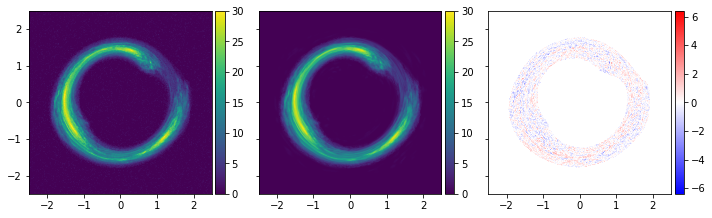

In [29]:
plot_fit_resids()

##### Parameters

gamma_1: +0.00668±0.00006 (0.007-0.000324: 5.6-sigma)
gamma_2: +0.01176±0.00039 (0.01+0.001764: 4.5-sigma)
    phi: +0.99823±0.00136 (1.0-0.001767: 1.3-sigma)
      q: +0.74984±0.00123 (0.75-0.000161: 0.1-sigma)
  r_ein: +1.49963±0.00070 (1.5-0.000374: 0.5-sigma)
      x: -0.05045±0.00061 (-0.05-0.000455: 0.7-sigma)
      y: +0.10049±0.00053 (0.1+0.000492: 0.9-sigma)


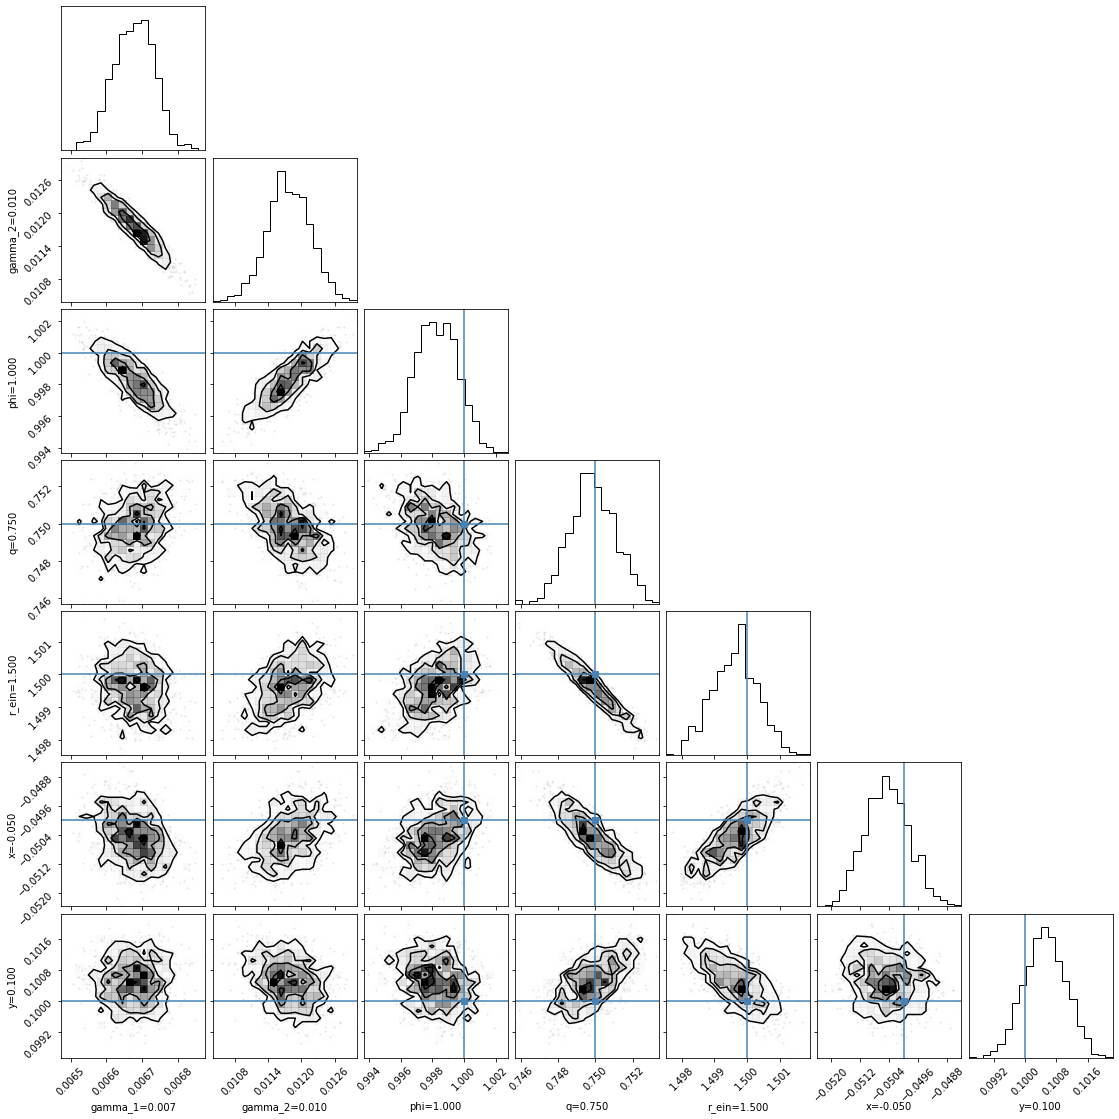

In [32]:
display_guide(PARAMS['truth'], guide.g, exclude=lambda name: name.startswith('src') or name.startswith('gp'));

##### Source plane

In [ ]:
# plot_source(gp)

In [ ]:
from skimage.transform import resize
from more_itertools import always_iterable
from itertools import chain

src_true = 30 * np.load(os.path.join('../../mock_data/sources', f'{SYSTEM_NAME}.npy'))

scale = PARAMS['scale']
SRCRES = src_true.shape[0]
srcimkwargs = dict(extent=2*(-scale/2, scale/2), origin='lower')

src_true = resize(src_true, (SRCRES, SRCRES))
psrc = torch.stack(get_meshgrid(scale / SRCRES, SRCRES, SRCRES), -1).reshape(-1, 2)

In [ ]:
guide_trace, model_trace = config.ppd().values()

In [ ]:
Xsrc, Ysrc = model_trace.nodes['Xsrc']['value'], model_trace.nodes['Ysrc']['value']
p_all = torch.stack((Xsrc, Ysrc), -1)[..., MASK, :]

In [ ]:
sigmas = tuple(chain(*(always_iterable(config.kwargs['defs'][key].sigma) for key in model.sources.keys())))
srcimgs = tuple(chain(*(
    src.flux(psrc).reshape(-1, SRCRES, SRCRES)
    for src in model.sources.values()
)))
srcimg = sum(srcimgs).squeeze()

In [ ]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))

# axs[0].plot(*p_all.T, 'r,')
imshow_with_cbar(ax=axs[0], img=src_true, **srcimkwargs, vmin=0, vmax=30)
imshow_with_cbar(axs[1], srcimg, **srcimkwargs, vmin=0, vmax=30)
imshow_with_cbar(
    axs[2],
    srcimg-src_true, **srcimkwargs, vmin=-5, vmax=5, cmap='bwr'
)

for sigma in sigmas:
    axs[1].add_artist(plt.Circle((-0.4, -0.4), radius=sigma, fill=False, ec='red', lw=1))

plt.tight_layout()

In [ ]:
guide.gp_alpha()[1]

In [ ]:
ncols = len(srcimgs) + 2
fig, axs = plt.subplots(1, ncols, sharex=True, sharey=True, figsize=(ncols*4+1, 4))
imshow_with_cbar(axs[0], src_true, **srcimkwargs)
imshow_with_cbar(axs[1], srcimg, **srcimkwargs)
for ax, _srcimg, sigma in zip(axs[2:], srcimgs, sigmas):
    imshow_with_cbar(ax, _srcimg, **srcimkwargs)
    ax.add_artist(plt.Circle((-0.4, -0.4), radius=sigma, fill=False, ec='red', lw=1))
plt.tight_layout()

In [ ]:
imshow_with_cbar(plt.gca(), sum(srcimgs[1:]), **srcimkwargs)